# Spatial relationship between cell populations

We applied STALOC on human squamous cell carcinoma (SCC) datasets to analyze the spatial relationship of cell populations on tumor microenvironment. The raw datasets can be downloaded from: Gene Expression Omnibus (GEO) accession [GSE144240](https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE144240). The anndata object of processed datasets can be downloaded from [Google Drive](https://drive.google.com/drive/folders/1a5FhWWs0dvUS4vhRGI7o_b5PXhfhNTdl).

In [1]:
import warnings
warnings.filterwarnings("ignore")
import os
import numpy as np
import pandas as pd
import scanpy as sc
import STALocator
import scipy.sparse as sp

## Read data

In [2]:
# Read ST dataset.
st_data_path = '../data/T3_ST/'

## Read the expression data.
count_ST=pd.read_csv(os.path.join(st_data_path, "GSM4284316_P2_ST_rep1_stdata.tsv"), sep="\t", index_col=0)

## Read the meta data with spatial location and filter out spots that are not in the meta data
meta_ST=pd.read_csv(os.path.join(st_data_path, "GSM4284316_spot_data-selection-P2_ST_rep1.tsv"), sep="\t")
meta_ST = meta_ST.set_index(meta_ST.apply(lambda meta_ST: str(int(meta_ST['x'])) + 'x' + str(int(meta_ST['y'])), axis=1))
count_ST=count_ST.loc[meta_ST.index,:]

## Expression data must be transformed to anndata object, and meta data must be added to it.
adata_ST=sc.AnnData(count_ST, obs=meta_ST)
adata_ST.obsm["spatial"]=adata_ST.obs[["x","y"]].to_numpy()

In [ ]:
# You can also read the processed h5ad file directly to run the model more easily.
#st_data_path = '../data/T3_ST/'
#adata_ST=sc.read(os.path.join(st_data_path, "SCC_st_P2.h5ad"))

In [3]:
adata_ST

AnnData object with n_obs × n_vars = 666 × 17138
    obs: 'x', 'y', 'new_x', 'new_y', 'pixel_x', 'pixel_y'
    obsm: 'spatial'

In [4]:
# Read scRNA-seq dataset.
sc_data_path="../data/T3_sc/"

## Read the meta data with cell type labels, tissue origins, and patients resource, etc.
meta_sc=pd.read_csv(os.path.join(sc_data_path, "patient_metadata_new.txt"), sep="\t", index_col=0)

## Read the expression data.
count_sc=pd.read_csv(os.path.join(sc_data_path, "merge10pts_counts.txt"), sep="\t", index_col=0)
count_sc=count_sc.iloc[2:,:]

## Expression data must be transformed to anndata object, and meta data must be added to it.
adata_sc=sc.AnnData(count_sc.T, obs=meta_sc)
adata_sc.X=sp.csr_matrix(adata_sc.X)

## Here we only use cells from the tumor tissue.
adata_sc=adata_sc[adata_sc.obs["tum.norm"]=="Tumor"]

## Cell type or spatial domain labels must be additionally stored in 'celltype' if they exist.
adata_sc.obs["celltype"]=adata_sc.obs["level3_celltype"]

In [ ]:
# You can also read the processed h5ad file directly to run the model more easily.
#sc_data_path="../data/T3_sc/"
#adata_sc=sc.read(os.path.join(sc_data_path, "SCC_scRNAseq_tumor.h5ad"))
#adata_sc.obs["celltype"]=adata_sc.obs["level3_celltype"]

In [5]:
adata_sc

AnnData object with n_obs × n_vars = 26299 × 32738
    obs: 'nCount_RNA', 'nFeature_RNA', 'patient', 'tum.norm', 'level1_celltype', 'level2_celltype', 'level3_celltype', 'celltype'

In [6]:
sc.pp.filter_genes(adata_ST, min_cells=3)
sc.pp.filter_genes(adata_sc, min_cells=3)

## Run model

In [7]:
experiment_path="T3"
if not os.path.exists(experiment_path):
    os.makedirs(experiment_path)

In [8]:
model = STALocator.model.Model(resolution="low", batch_size=200, train_epoch=10000, cut_steps=0.5, sf_coord=50, rad_cutoff=1.2, 
                               seed=1234, lambdacos=10, lambdaSWD=5, lambdalat=10, lambdarec=0.1,
                               model_path = "T3/models", data_path = "T3/data", result_path = "T3/results", 
                               ot=False, device="cuda:0")

In [9]:
model.preprocess(adata_sc, adata_ST)

Finding highly variable genes...
Normalizing and scaling...
Dimensionality reduction via PCA...


In [10]:
model.train()

Begining time:  Wed Mar 27 01:47:27 2024
step 0, total_loss=636.9995, loss_D=13.1930, loss_GAN=3.2834, loss_AE=32.1274, loss_cos=1.8986, loss_LA=25.3511, loss_SWD=7.9891
step 500, total_loss=22.8501, loss_D=1.1145, loss_GAN=5.8904, loss_AE=0.7996, loss_cos=0.5116, loss_LA=0.2182, loss_SWD=0.3332
step 1000, total_loss=19.3517, loss_D=0.8923, loss_GAN=5.7736, loss_AE=0.6515, loss_cos=0.4880, loss_LA=0.1258, loss_SWD=0.1851
step 1500, total_loss=17.7318, loss_D=0.6294, loss_GAN=7.0710, loss_AE=0.4477, loss_cos=0.4409, loss_LA=0.0972, loss_SWD=0.1607
step 2000, total_loss=17.1184, loss_D=0.6903, loss_GAN=7.6427, loss_AE=0.4239, loss_cos=0.3769, loss_LA=0.0885, loss_SWD=0.1166
step 2500, total_loss=16.5777, loss_D=0.7331, loss_GAN=7.8721, loss_AE=0.3925, loss_cos=0.3446, loss_LA=0.0779, loss_SWD=0.1109
step 3000, total_loss=16.1696, loss_D=0.6260, loss_GAN=7.9233, loss_AE=0.3703, loss_cos=0.3330, loss_LA=0.0647, loss_SWD=0.1133
step 3500, total_loss=15.6932, loss_D=0.4980, loss_GAN=8.0878, 

In [11]:
model.eval()

Localized scRNA-seq dataset has been saved!


In [12]:
adata_total = model.adata_total
adata_sc = model.adata_A_input
adata_ST = model.adata_B_input
adata_sc_keep = model.adata_A_keep

In [13]:
adata_sc_keep

View of AnnData object with n_obs × n_vars = 26094 × 23458
    obs: 'nCount_RNA', 'nFeature_RNA', 'patient', 'tum.norm', 'level1_celltype', 'level2_celltype', 'level3_celltype', 'celltype', 'batch'
    var: 'n_cells', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: 'hvg', 'log1p'
    obsm: 'loc'

## Visualization of localization results

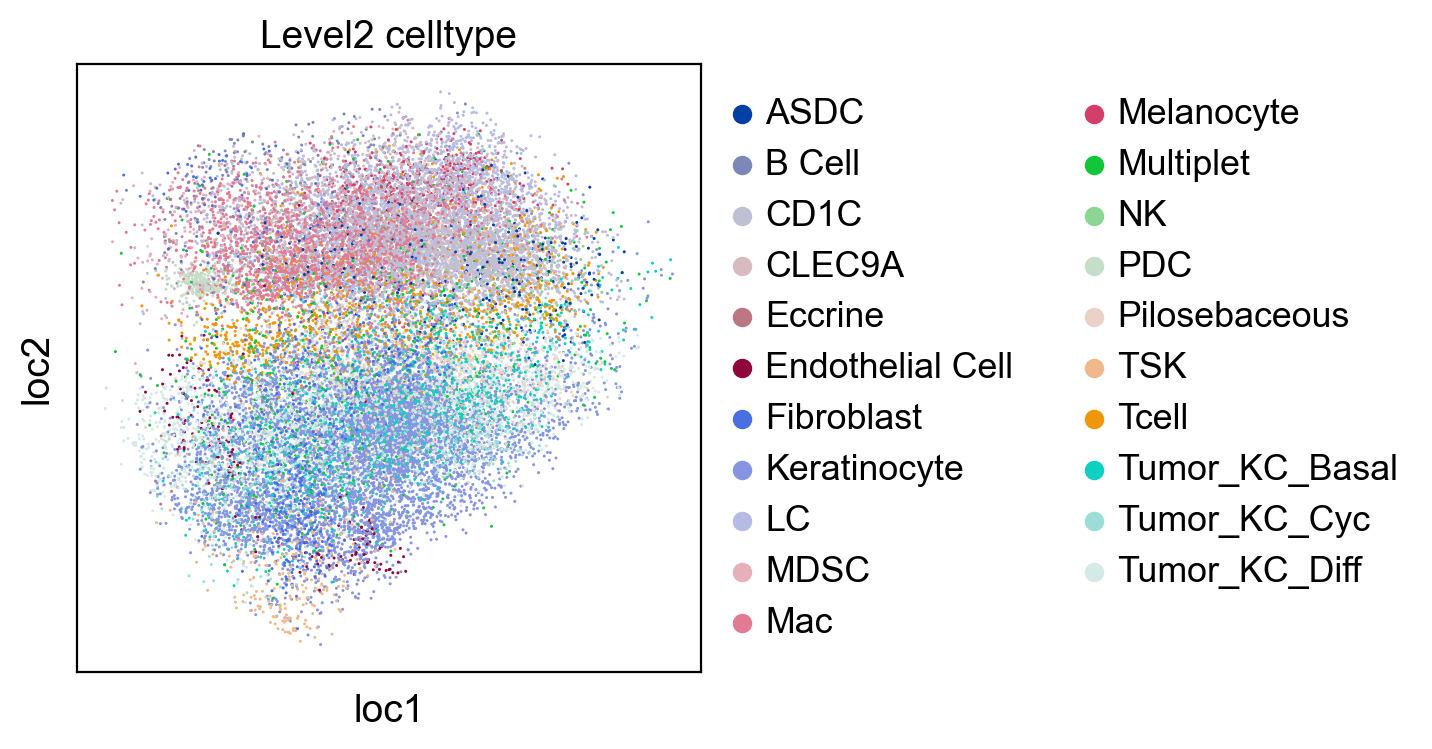

In [15]:
sc.set_figure_params(dpi=100, figsize=(4, 4))
sc.pl.embedding(adata_sc_keep, basis="loc", color="level2_celltype", title="Level2 celltype")

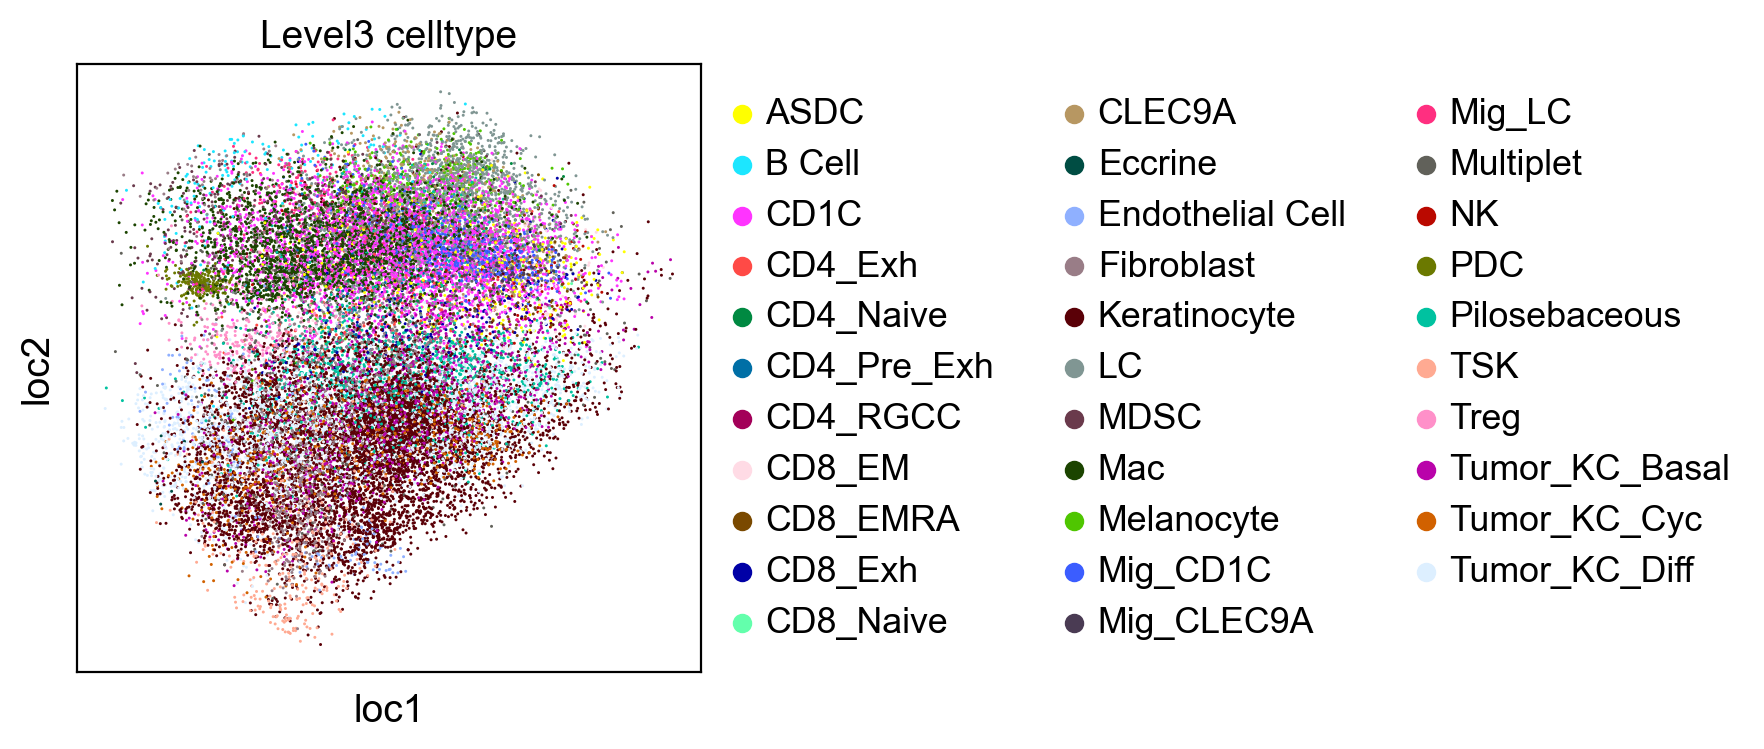

In [16]:
sc.set_figure_params(dpi=100, figsize=(4, 4))
sc.pl.embedding(adata_sc_keep, basis="loc", color="level3_celltype", title="Level3 celltype")

## Distance to tumor-specific keratinocytes (TSKs)

In [17]:
from scipy.spatial.distance import cdist
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from matplotlib.lines import Line2D

In [18]:
select_celltype=["TSK","Treg","CD8_Exh","CD4_Naive","CD4_Exh","CD8_Naive","Fibroblast","Pilosebaceous","Endothelial Cell","Keratinocyte"]

In [19]:
# The distance of each cell in the TSKs to the nearest cell in the other selected cell population is calculated here.
cell_map_df=pd.DataFrame(adata_sc_keep.obsm["loc"], index=adata_sc_keep.obs.index, columns=["coor_x","coor_y"])
cell_map_df["label"]=adata_sc_keep.obs["level3_celltype"].astype("str")
cell_map_df=cell_map_df[cell_map_df["label"].isin(select_celltype)]
grouped = cell_map_df.groupby('label')
ref_samples = grouped.get_group("TSK")[['coor_x', 'coor_y']].values
min_distances = {}
for label, group in grouped:
    if label != "TSK":
        samples = group[['coor_x', 'coor_y']].values
        distances = cdist(samples, ref_samples)
        min_dist = np.min(distances, axis=1)
        min_distances[label] = min_dist
sorted_distances = sorted(min_distances.items(), key=lambda x: np.median(x[1]))

In [20]:
sc_level3_celltype_color=adata_sc_keep.uns["level3_celltype_colors"]
sc_level3_celltype_color=pd.DataFrame(sc_level3_celltype_color, index=adata_sc_keep.obs["level3_celltype"].cat.categories, columns=["color"])

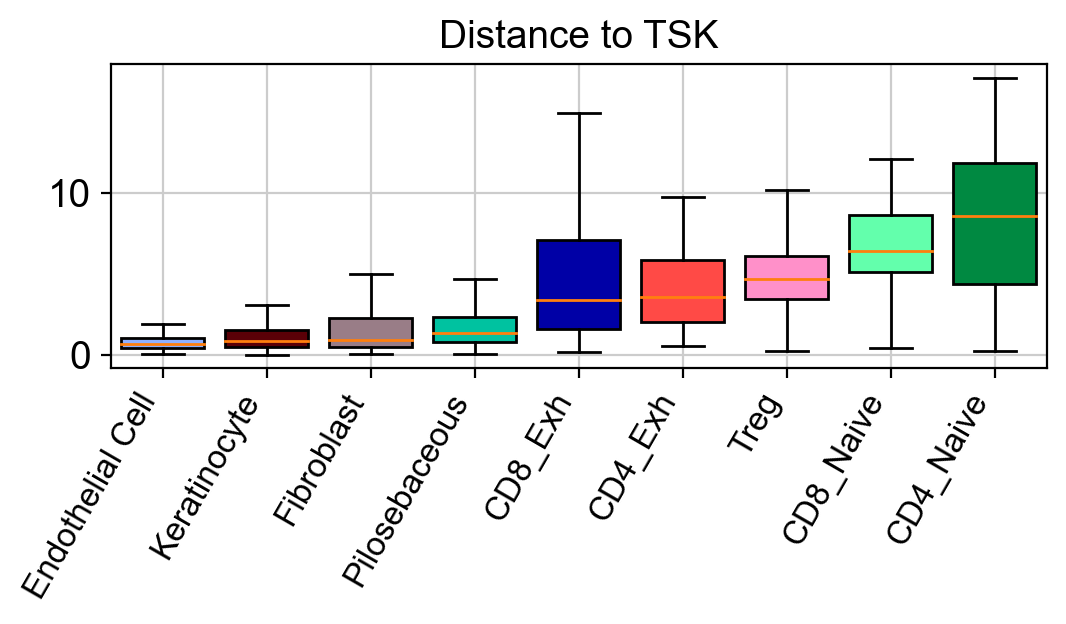

In [21]:
sc.set_figure_params(dpi=100, figsize=(6, 2))
labels = [item[0] for item in sorted_distances]
distances = [item[1] for item in sorted_distances]
fig, ax = plt.subplots()
boxplot = ax.boxplot(distances, sym='k+', showfliers=False, widths=0.8, vert=True, patch_artist=True)
colors = sc_level3_celltype_color.loc[labels,"color"]
for patch, color in zip(boxplot['boxes'], colors):
    patch.set_facecolor(color)
plt.xticks(range(1, len(labels) + 1), labels, rotation=60, ha='right', fontsize=12)
plt.title("Distance to TSK")
plt.show()

## Tertiary lymphoid structure (TLS)

In [22]:
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from scipy.stats import pearsonr

In [23]:
N = 256
vals = np.ones((N, 4))
vals[:, 0] = np.linspace(0.9, 0.24705882, N)
vals[:, 1] = np.linspace(0.9, 0, N)
vals[:, 2] = np.linspace(0.9, 0.49019608, N)
newcmp = ListedColormap(vals)

In [24]:
# TLS include T cells and B cells.
adata_sc_keep.obs["level4_celltype"]=adata_sc_keep.obs["level1_celltype"]
adata_sc_keep.obs["level4_celltype"]=adata_sc_keep.obs["level4_celltype"].replace({"Tcell": "TLS", "B Cell": "TLS"})

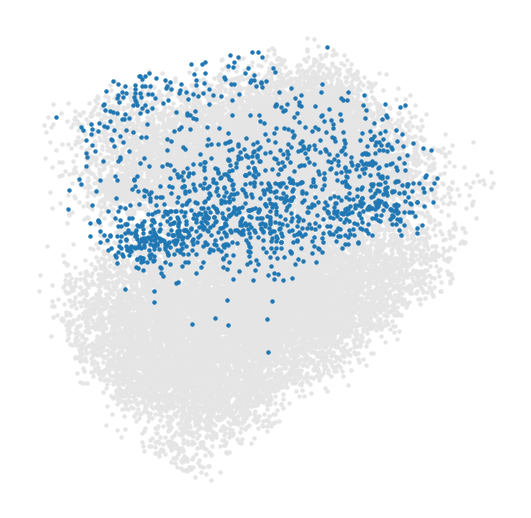

In [25]:
sc.set_figure_params(dpi=80, figsize=(4, 4))
x=np.array(adata_sc_keep[-adata_sc_keep.obs["level1_celltype"].isin(["Tcell","B Cell"])].obsm["loc"][:,0])
y=np.array(adata_sc_keep[-adata_sc_keep.obs["level1_celltype"].isin(["Tcell","B Cell"])].obsm["loc"][:,1])
plt.scatter(x,y,s=1, c="#e5e5e5")
x=np.array(adata_sc_keep[adata_sc_keep.obs["level1_celltype"].isin(["Tcell","B Cell"])].obsm["loc"][:,0])
y=np.array(adata_sc_keep[adata_sc_keep.obs["level1_celltype"].isin(["Tcell","B Cell"])].obsm["loc"][:,1])
plt.scatter(x,y,s=1)
plt.xticks([])
plt.yticks([])
plt.grid(False)
plt.axis('off')
plt.show()

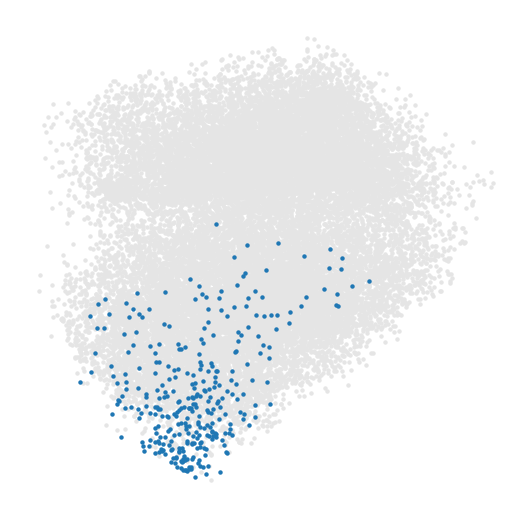

In [26]:
sc.set_figure_params(dpi=80, figsize=(4, 4))
x=np.array(adata_sc_keep[-adata_sc_keep.obs["level2_celltype"].isin(["TSK"])].obsm["loc"][:,0])
y=np.array(adata_sc_keep[-adata_sc_keep.obs["level2_celltype"].isin(["TSK"])].obsm["loc"][:,1])
plt.scatter(x,y,s=1,c="#e5e5e5")
x=np.array(adata_sc_keep[adata_sc_keep.obs["level2_celltype"].isin(["TSK"])].obsm["loc"][:,0])
y=np.array(adata_sc_keep[adata_sc_keep.obs["level2_celltype"].isin(["TSK"])].obsm["loc"][:,1])
plt.scatter(x,y,s=1)
plt.xticks([])
plt.yticks([])
plt.grid(False)
plt.axis('off')
plt.show()

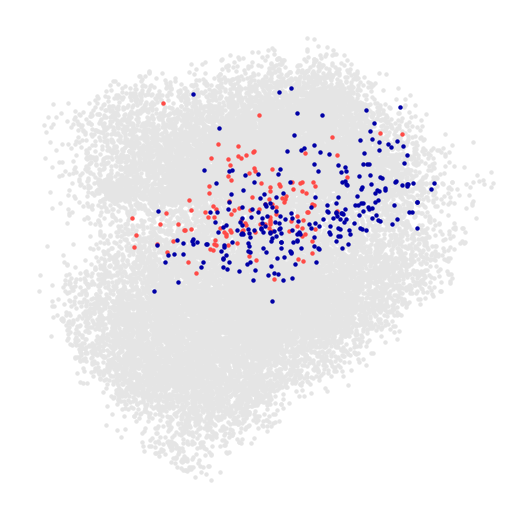

In [27]:
sc.set_figure_params(dpi=80, figsize=(4, 4))
x=np.array(adata_sc_keep[-adata_sc_keep.obs["level3_celltype"].isin(["CD4_Exh","CD8_Exh"])].obsm["loc"][:,0])
y=np.array(adata_sc_keep[-adata_sc_keep.obs["level3_celltype"].isin(["CD4_Exh","CD8_Exh"])].obsm["loc"][:,1])
plt.scatter(x,y,s=1,c="#e5e5e5")
x=np.array(adata_sc_keep[adata_sc_keep.obs["level3_celltype"].isin(["CD4_Exh"])].obsm["loc"][:,0])
y=np.array(adata_sc_keep[adata_sc_keep.obs["level3_celltype"].isin(["CD4_Exh"])].obsm["loc"][:,1])
plt.scatter(x,y,s=1,c="#ff4a46")
x=np.array(adata_sc_keep[adata_sc_keep.obs["level3_celltype"].isin(["CD8_Exh"])].obsm["loc"][:,0])
y=np.array(adata_sc_keep[adata_sc_keep.obs["level3_celltype"].isin(["CD8_Exh"])].obsm["loc"][:,1])
plt.scatter(x,y,s=1,c="#0000a6")
plt.xticks([])
plt.yticks([])
plt.grid(False)
plt.axis('off')
plt.show()

In [28]:
# T-exhaustion genes from the original paper.
T_exhaustion_gene=["LAG3","TIGIT","PDCD1","HAVCR2","CTLA4","BTLA","KLRC1","ENTPD1","LAYN"]

In [29]:
# The T-exhaustion score was defined as the combined expression of T-exhaustion genes.
T_exhaustion_score_ST=pd.DataFrame(np.mean(adata_ST[:,T_exhaustion_gene].X, axis=1), 
                                   index=adata_ST.obs.index, 
                                   columns=["exhaustion_score"])
adata_ST.obs.loc[T_exhaustion_score_ST.index,T_exhaustion_score_ST.columns]=T_exhaustion_score_ST

(4.85, 52.15, 9.8, 58.2)

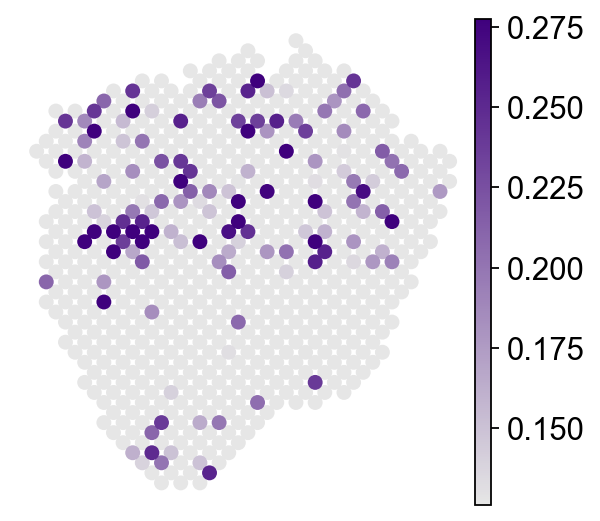

In [30]:
sc.set_figure_params(dpi=80, figsize=(4, 4))
sc.pl.embedding(adata_ST, basis="spatial", color="exhaustion_score", title="", 
                color_map=newcmp, show=False, vmin="p80", vmax="p97")
plt.axis('off')

In [31]:
# The T-exhaustion score was defined as the combined expression of T-exhaustion genes.
T_exhaustion_score_sc_keep=pd.DataFrame(np.mean(adata_sc_keep[:,T_exhaustion_gene].X, axis=1), 
                                        index=adata_sc_keep.obs.index, 
                                        columns=["exhaustion_score"])
adata_sc_keep.obs.loc[T_exhaustion_score_sc_keep.index,T_exhaustion_score_sc_keep.columns]=T_exhaustion_score_sc_keep

In [32]:
# T-exhaustion score and distance from TSKs of T cells.
cell_map_df.loc[:,["exhaustion_score","level1_celltype"]]=\
adata_sc_keep.obs.loc[cell_map_df.index,["exhaustion_score","level1_celltype"]]
T_map_df=cell_map_df[cell_map_df["level1_celltype"]=="Tcell"]
distances = cdist(T_map_df[["coor_x","coor_y"]], ref_samples)
min_dist = np.min(distances, axis=1)
min_dist_df=pd.DataFrame(min_dist, index=T_map_df.index, columns=["Dist_with_TSK"])
T_map_df["Dist_with_TSK"]=min_dist_df["Dist_with_TSK"]

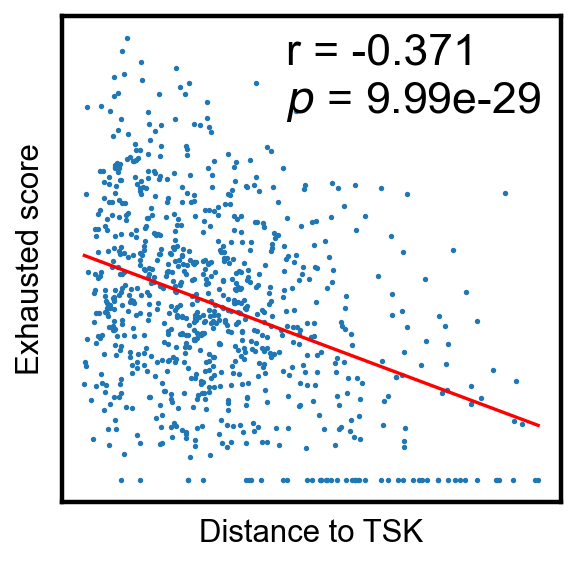

In [33]:
sc.set_figure_params(dpi=80, figsize=(4, 4))
x=T_map_df["Dist_with_TSK"]
y=T_map_df["exhaustion_score"]
coefficients = np.polyfit(x, y, 1)
poly = np.poly1d(coefficients)
x_fit = np.linspace(x.min(), x.max(), 100)
y_fit = poly(x_fit)
corr, p_value = pearsonr(x, y)
plt.scatter(x,y, s=2)
plt.plot(x_fit, y_fit, color='red')
text = fr'$\mathit{{p}}$ = {p_value:.2e}'
plt.text(0.45, 0.8, f'r = {corr:.3f}\n{text}', fontsize=20, transform=plt.gca().transAxes)
plt.xticks([])
plt.yticks([])
plt.grid(False)
plt.xlabel('Distance to TSK')
plt.ylabel('Exhausted score')
ax = plt.gca()
for spine in ax.spines.values():
    spine.set_edgecolor('black')
    spine.set_linewidth(2)
plt.show()

In [34]:
# Sort the important T cell subpopulations according to T-exhaustion score.
grouped = T_map_df.groupby('label')['exhaustion_score']
T_exhaustion_dict={}
for label, group in grouped:
    T_exhaustion_dict[label]=group
sorted_T_exhaust = sorted(T_exhaustion_dict.items(), key=lambda x: np.median(x[1]), reverse=True)

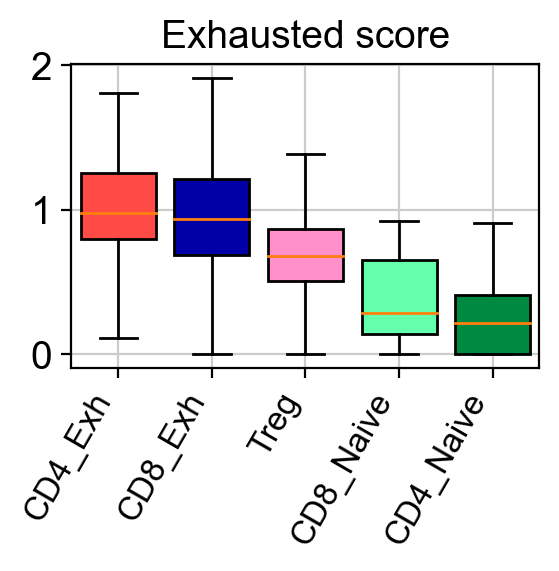

In [35]:
sc.set_figure_params(dpi=100, figsize=(3, 2))
labels = [item[0] for item in sorted_T_exhaust]
distances = [item[1] for item in sorted_T_exhaust]
fig, ax = plt.subplots()
boxplot = ax.boxplot(distances, sym='k+', showfliers=False, widths=0.8, vert=True, patch_artist=True)
colors = sc_level3_celltype_color.loc[labels,"color"]
for patch, color in zip(boxplot['boxes'], colors):
    patch.set_facecolor(color)
plt.xticks(range(1, len(labels) + 1), labels, rotation=60, ha='right', fontsize=12)
plt.title("Exhausted score")
#plt.savefig("../../figures/Exhausted_score_scRNAseq.png", bbox_inches='tight')
plt.show()

## Defining "surrouding immune cells"

In [36]:
select_celltype=["Tcell","B Cell"]

In [37]:
# Defines immune cells (including T cells and B cells) within a given distance from TSKs as "surrounding immune cells"
sc_level1_celltype_unique=adata_sc_keep.obs["level1_celltype"].unique().astype("str")
cell_map_df=pd.DataFrame(adata_sc_keep.obsm["loc"], index=adata_sc_keep.obs.index, columns=["coor_x","coor_y"])
cell_map_df["label"]=adata_sc_keep.obs["level1_celltype"].astype("str")
cell_map_df=cell_map_df[cell_map_df["label"].isin(select_celltype)]
TSK_map_df = pd.DataFrame(adata_sc_keep.obsm["loc"], index=adata_sc_keep.obs.index, columns=["coor_x","coor_y"])
TSK_map_df["label"]=adata_sc_keep.obs["level3_celltype"].astype("str")
TSK_map_df=TSK_map_df[TSK_map_df["label"].isin(["TSK"])]
distances = cdist(cell_map_df.iloc[:,0:2], TSK_map_df.iloc[:,0:2])
min_dist = np.min(distances, axis=1)
cell_map_df=cell_map_df[min_dist<1]
cell_map_df["label"]="TSK_immune"

In [38]:
cell_map_df.head()

,coor_x,coor_y,label
P2_Tumor_AGCATACCAAGGTTCT,29.858828,29.390463,TSK_immune
P2_Tumor_CAAGTTGAGAGCTGCA,29.756445,34.874569,TSK_immune
P2_Tumor_CCGGGATCACCGCTAG,27.491760,33.213791,TSK_immune
P2_Tumor_GTTAAGCCAAGAGTCG,25.239204,37.007210,TSK_immune
P2_Tumor_TACTCATAGATCCGAG,26.184229,34.173153,TSK_immune


In [39]:
adata_sc_keep.obs["microenv"]="other"
adata_sc_keep.obs.loc[cell_map_df.index,"microenv"]=cell_map_df["label"]
adata_sc_keep.obs.loc[TSK_map_df.index,"microenv"]=TSK_map_df["label"]

In [40]:
adata_sc_keep.obs.to_csv("../data/T3_sc/adata_sc_keep_obs.csv")